# 线性模型方程：间断处的非物理振荡
$$\frac{\partial u}{\partial t}+a\frac{\partial u}{\partial x}=0, a=1,\quad u(x,0)=\begin{cases}0,&x<0.5\\1,&x\le0.5\end{cases}\quad x\in [0,1] $$

In [59]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def init(nx):
    '''
    Initialization of the linear modal equation.
    ============================================
    input: a: sound speed, 1 or -1
    output: u, x
    '''
    dx = 1 / (nx - 1)
    x = np.array([i*dx for i in range(nx)])
    u = x.copy()
    u[:int(nx/2)] = 0
    u[int(nx/2):] = 1
    return u, x


def flux(u, a):
    '''
    Calculate the physical flux.
    ============================
    input: u: physical variable
           a: wave phase speed
    output: f = au
    '''
    fu = a * u
    return fu

## 激波捕捉格式
- 参考：李新亮，《计算流体力学》课件 (PPT) 第 4 讲
- 代码实现：计算中间数值通量，边界点不做处理
- 守恒格式
$$\frac{\partial f}{\partial x}\Big|_j=\frac{\hat{f}_{j+1/2}-\hat{f}_{j-1/2}}{\Delta x} $$
- TVD
$$\hat{f}_{j+1/2}=f_j+\phi_j(r_j)(f_{j+1}-f_j)/2\quad r_j=\frac{f_j-f_{j-1}}{f_{j+1}-f_j} $$
$$\text{Van Leer: }\phi(r)=\frac{|r|+r}{|r|+1}=\begin{cases}\frac{2r}{r+1}&r>0\\0&r\le 0 \end{cases} $$
- GVC：群速度控制格式
  - 二阶中心，快格式，波前振荡，应放到下游去
  - 二阶迎风，慢格式，波后振荡，应放到上游去
  $$\hat{f}_{j+1/2}=\begin{cases}(3f_j-f_{j-1})/2&|f_j-f_{j-1}|<|f_{j+1}-f_j |\\(f_j+f_{j+1})/2&|f_j-f_{j-1} |\ge|f_{j+1}-f_j | \end{cases} $$
- MUSCL
$$f_{j+1/2}^{\rm{MUSCL3}}=f_j+\frac{s}{4}[(1-\frac{s}{3})\delta_x^-+(1+\frac{s}{3})\delta_x^+]f_j\qquad\delta^-f_j=f_j-f_{j-1},\delta^+f_j=f_{j+1}-f_j $$
$$s=\frac{2\delta^-f_j\delta^+f_j+\varepsilon}{(\delta^-f_j)^2+(\delta^+f_j)^2+\varepsilon}\qquad \varepsilon=10^{-6} $$
光滑区：$\delta^-f_j\approx\delta^+f_j\Rightarrow s\to 1\qquad f_{j+1/2}^{\rm{MUSCL3}}=(-f_{j-1}+5u_j+2u_{j+1})/6\quad\text{3阶迎风} $

非光滑区：$s\to 0\hspace{12em} f_{j+1/2}^{\rm{MUSCL3}}\to f_j\qquad\text{1阶迎风} $
- NND
$$\hat{f}_{j+1/2}=f_j+\frac{1}{2}\text{minmod}(f_j-f_{j-1},f_{j+1}-f_j) $$
- WENO5
   - 3个子模板，每个子模板4个基架点，3阶精度。按光滑度加权，都光滑逼近5阶精度(总的6个基架点)
   - 边界条件处理：用到边界外的点，模板权重设为0，效果不过，但边界降阶
   $$\hat{f}_{j+1/2}^{\rm{WENO}}=w_1\hat{f}_{j+1/2}^{(1)}+w_2\hat{f}_{j+1/2}^{(2)}+w_3\hat{f}_{j+1/2}^{(3)} $$
   $$\hat{f}_{j+1/2}^{(1)}=\frac{1}{3}f_{j-2}-\frac{7}{6}f_{j-1}+\frac{11}{6}f_j\quad \hat{f}_{j+1/2}^{(2)}=-\frac{1}{6}f_{j-1}+\frac{5}{6}f_{j}+\frac{1}{3}f_{j+1}$$
   $$\hat{f}_{j+1/2}^{(3)}=\frac{1}{3}f_{j}+\frac{5}{6}f_{j+1}-\frac{1}{6}f_{j+2}\qquad w_k=\frac{\alpha_k}{\alpha_1+\alpha_2+\alpha_3} $$
   $$\alpha_k=\frac{C_k}{(\varepsilon+IS_k)^2},\varepsilon=10^{-6}\qquad C_1=\frac{1}{10},C_2=\frac{6}{10},C_3=\frac{3}{10} $$
   $$IS_1=\frac{1}{4}(f_{j-2}-4f_{j-1}+3f_j)^2+\frac{13}{12}(f_{j-2}-2f_{j-1}+f_j)^2 $$
   $$IS_2=\frac{1}{4}(f_{j-1}-f_{j+1})^2+\frac{13}{12}(f_{j-1}-2f_{j}+f_{j+1})^2 $$
   $$IS_3=\frac{1}{4}(3f_{j}-4f_{j+1}+f_{j+2})^2+\frac{13}{12}(f_{j}-2f_{j+1}+f_{j+2})^2 $$

In [60]:
def van_leer_limiter(dm, dp): # delta^-, delta^+
    '''
    input: dm: delta^-, f_j - f_{j-1}
           dp: delta^+, f_{j+1} - f_j
    '''
    phi = np.zeros(dm.size)
    r = dm / dp
    index = r > 0
    phi[index] = 2*r[index]/(r[index]+1)
    index = r <= 0
    phi[index] = 0
    index = np.abs(r) == np.inf
    phi[index] = 2
    return phi


def TVD_van_leer_pos(f, KL, KR):
    '''
    Numerical flux for positive wave speed with Van Leer Type TVD scheme.
    '''
    fx = f[-KL:-KR] + van_leer_limiter(f[-KL:-KR]-f[-KL-1:-KR-1],f[-KL+1:-KR+1]-f[-KL:-KR])\
        *(f[-KL+1:-KR+1]-f[-KL:-KR])/2
    return fx


def TVD_van_leer_neg(f, KL, KR):
    '''
    Numerical flux for negative wave speed with Van Leer Type TVD scheme.
    '''
    fx = f[-KL+1:-KR+1] + van_leer_limiter(f[-KL+1:-KR+1]-f[-KL+2:],f[-KL:-KR]-f[-KL+1:-KR+1])\
        *(f[-KL:-KR]-f[-KL+1:-KR+1])/2
    return fx

In [61]:
def GVC_pos(f, KL, KR):
    '''
    GVC numerical flux for positive wave speed.
    ================================================================
    output: f_{j+1/2}
    '''
    delta_m = f[-KL:-KR] - f[-KL-1:-KR-1] # f_j - f_{j-1}
    delta_p = f[-KL+1:-KR+1] - f[-KL:-KR] # f_{j+1} - f_j
    upwind2 = (3*f[-KL:-KR] - f[-KL-1:-KR-1])/2
    center2 = (f[-KL:-KR] + f[-KL+1:-KR+1])/2
    fx = delta_m.copy()
    index = np.abs(delta_m) < np.abs(delta_p)
    fx[index] = upwind2[index]
    index = np.abs(delta_m) >= np.abs(delta_p)
    fx[index] = center2[index]
    return fx


def GVC_neg(f, KL, KR):
    '''
    GVC numerical flux for negative wave speed.
    ================================================================
    output: f_{j+1/2}
    '''
    delta_p = f[-KL:-KR] - f[-KL+1:-KR+1] # f_j - f_{j+1}
    delta_pp = f[-KL+1:-KR+1] - f[-KL+2:] # f_{j+1} - f_{j+2}
    upwind2 = (3*f[-KL+1:-KR+1] - f[-KL+2:])/2
    center2 = (f[-KL:-KR] + f[-KL+1:-KR+1])/2
    fx = delta_p.copy()
    index = np.abs(delta_pp) < np.abs(delta_p)
    fx[index] = upwind2[index]
    index = np.abs(delta_pp) >= np.abs(delta_p)
    fx[index] = center2[index]
    return fx

In [62]:
def smooth_deg(dm, dp): # delta^-, delta^+
    epsilon = 1e-6
    s = (2*dm*dp+epsilon)/(dm*dm+dp*dp+epsilon)
    return s


def MUSCL_pos(f, KL, KR):
    delta_m = f[-KL:-KR] - f[-KL-1:-KR-1] # f_j-f_{j-1}
    delta_p = f[-KL+1:-KR+1] - f[-KL:-KR] # f_{j+1}-f_j
    s = smooth_deg(delta_m, delta_p)
    fx = f[-KL:-KR] + s/4*((1-s/3)*delta_m+(1+s/3)*delta_p)
    return fx


def MUSCL_neg(f, KL, KR):
    delta_p = f[-KL:-KR] - f[-KL+1:-KR+1] # f_j - f_{j+1}
    delta_pp = f[-KL+1:-KR+1] - f[-KL+2:] # f_{j+1} - f_{j+2}
    s = smooth_deg(delta_pp, delta_p)
    fx = f[-KL+1:-KR+1] + s/4*((1-s/3)*delta_pp+(1+s/3)*delta_p)
    return fx

In [63]:
def minmod(a, b): # 同号(不为0)取绝对值小的，否则取0
    temp = np.zeros(a.size)
    for i in range(a.size):
        if a[i] * b[i] > 0:
            if np.abs(a[i]) > np.abs(b[i]):
                temp[i] = b[i]
            else:
                temp[i] = a[i]
        else:
            temp[i] = 0
    return temp


def NND_pos(f, KL, KR):
    '''
    NND numerical flux for positive wave speed.
    ===========================================
    input: f: f_j
    output: fx: f_{j+1/2}, (nx-1,)
    '''
    fx = f[-KL:-KR] + 1/2*minmod(f[-KL:-KR]-f[-KL+1:-KR+1], f[-KL-1:-KR-1]-f[-KL:-KR])
    return fx


def NND_neg(f, KL, KR):
    '''
    NND numerical flux for negative wave speed.
    ===========================================
    input: f: f_j
    output: fx: f_{j+1/2}, (nx-1,)
    '''
    fx = f[-KL+1:-KR+1] + 1/2*minmod(f[-KL:-KR]-f[-KL+1:-KR+1], f[-KL+1:-KR+1]-f[-KL+2:])
    return fx

In [64]:
def WENO5_pos(f, KL, KR):
    epsilon = 1e-6
    C1 = 1/10; C2 = 6/10; C3 = 3/10

    # f_{j+1/2}
    fx_1 = 1/3*f[-KL-2:-KR-2] - 7/6*f[-KL-1:-KR-1] + 11/6*f[-KL:-KR]
    fx_2 = -1/6*f[-KL-1:-KR-1] + 5/6*f[-KL:-KR] + 1/3*f[-KL+1:-KR+1]
    fx_3 = 1/3*f[-KL:-KR] + 5/6*f[-KL+1:-KR+1] - 1/6*f[-KL+2:-KR+2]
    IS1 = 1/4*(f[-KL-2:-KR-2]-4*f[-KL-1:-KR-1]+3*f[-KL:-KR])**2 + 13/12*(f[-KL-2:-KR-2]-2*f[-KL-1:-KR-1]+f[-KL:-KR])**2
    IS2 = 1/4*(f[-KL-1:-KR-1]-f[-KL+1:-KR+1])**2 + 13/12*(f[-KL-1:-KR-1]-2*f[-KL:-KR]+f[-KL+1:-KR+1])**2
    IS3 = 1/4*(3*f[-KL:-KR]-4*f[-KL+1:-KR+1]+f[-KL+2:-KR+2])**2 + 13/12*(f[-KL:-KR]-2*f[-KL+1:-KR+1]+f[-KL+2:-KR+2])**2
    alpha1 = C1/(epsilon+IS1)**2
    alpha2 = C2/(epsilon+IS2)**2
    alpha3 = C3/(epsilon+IS3)**2
    w1 = alpha1/(alpha1+alpha2+alpha3) 
    w2 = alpha2/(alpha1+alpha2+alpha3) 
    w3 = alpha3/(alpha1+alpha2+alpha3)
    fx = w1*fx_1 + w2*fx_2 + w3*fx_3
    
    return fx


def WENO5_neg(f, KL, KR):
    epsilon = 1e-6
    C1 = 1/10; C2 = 6/10; C3 = 3/10

    # f_{j+1/2}
    fx_1 = 1/3*f[-KL+3:] - 7/6*f[-KL+2:-KR+2] + 11/6*f[-KL+1:-KR+1]
    fx_2 = -1/6*f[-KL+2:-KR+2] + 5/6*f[-KL+1:-KR+1] + 1/3*f[-KL:-KR]
    fx_3 = 1/3*f[-KL+1:-KR+1] + 5/6*f[-KL:-KR] - 1/6*f[-KL-1:-KR-1]
    IS1 = 1/4*(f[-KL+3:]-4*f[-KL+2:-KR+2]+3*f[-KL+1:-KR+1])**2 + 13/12*(f[-KL+3:]-2*f[-KL+2:-KR+2]+f[-KL+1:-KR+1])**2
    IS2 = 1/4*(f[-KL+2:-KR+2]-f[-KL:-KR])**2 + 13/12*(f[-KL+2:-KR+2]-2*f[-KL+1:-KR+1]+f[-KL:-KR])**2
    IS3 = 1/4*(3*f[-KL+1:-KR+1]-4*f[-KL:-KR]+f[-KL-1:-KR-1])**2 + 13/12*(f[-KL+1:-KR+1]-2*f[-KL:-KR]+f[-KL-1:-KR-1])**2
    alpha1 = C1/(epsilon+IS1)**2
    alpha2 = C2/(epsilon+IS2)**2
    alpha3 = C3/(epsilon+IS3)**2
    w1 = alpha1/(alpha1+alpha2+alpha3) 
    w2 = alpha2/(alpha1+alpha2+alpha3) 
    w3 = alpha3/(alpha1+alpha2+alpha3)
    fx = w1*fx_1 + w2*fx_2 + w3*fx_3
    
    return fx

## 时间推进方法 
### 显格式：3阶Runge-Kutta(TVD)
$$\frac{\partial U}{\partial t}=Q(U) $$
$$\begin{cases}U^{(1)}=&U^n+\Delta tQ(U^n)\\U^{(2)}=&\frac{3}{4}U^n+\frac{1}{4}U^{(1)}+\frac{1}{4}\Delta tQ(U^{(1)})\\U^{n+1}=&\frac{1}{3}U^n+\frac{2}{3}U^{(2)}+\frac{2}{3}\Delta tQ(U^{(2)}) \end{cases} $$

In [65]:
def runge_kutta(un, u, fx, dt, dx, order, KL, KR):
    '''
    input: un: physical variable at the previous step
    '''
    du = -(fx[1:]-fx[:-1])/dx
    if order == 1:
        u[-KL+1:-KR] = un[-KL+1:-KR] + dt * du
    elif order == 2:
        u[-KL+1:-KR] = 3/4*un[-KL+1:-KR] + 1/4*u[-KL+1:-KR] + 1/4*dt*du
    elif order == 3:
        u[-KL+1:-KR] = 1/3*un[-KL+1:-KR] + 2/3*u[-KL+1:-KR] + 2/3*dt*du
    return u

time step = 75 and total time = 0.3000000000000002


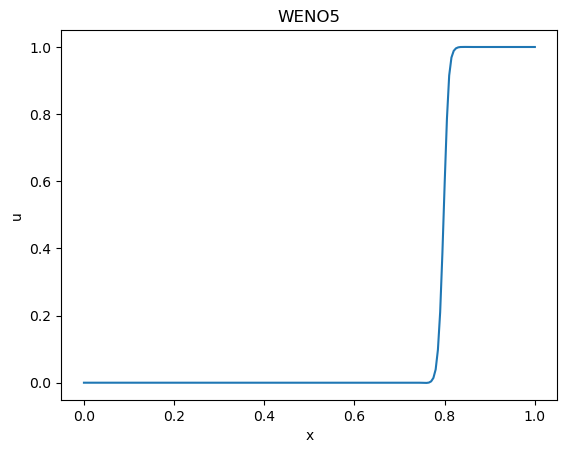

In [69]:
nx = 201
a = 1
CFL = 0.8
t = 0
tstep = 0
t_end = 0.3
TVD = 1; GVC = 2; MUSCL = 3; NND = 4; WENO5 = 5
scheme_type = 5

u, x = init(nx)
dx = x[1] - x[0]
dt = CFL * dx / np.abs(a)

while t < t_end:
    un = u.copy()
    for order in range(1,4):
        fu = flux(u, a)
        if scheme_type == TVD:
            KL = -1; KR = 2 # 描述差分格式使用的网格基架点
            title = 'TVD Van Leer'
            if a > 0:
                fx = TVD_van_leer_pos(fu, KL, KR)
            elif a < 0:
                fx = TVD_van_leer_neg(fu, KL, KR)
        elif scheme_type == GVC:
            KL = -1; KR = 2 # 描述差分格式使用的网格基架点
            title = 'GVC'
            if a > 0:
                fx = GVC_pos(fu, KL, KR)
            elif a < 0:
                fx = GVC_neg(fu, KL, KR)
        elif scheme_type == MUSCL:
            KL = -1; KR = 2 # 描述差分格式使用的网格基架点
            title = 'MUSCL'
            if a > 0:
                fx = MUSCL_pos(fu, KL, KR)
            elif a < 0:
                fx = MUSCL_neg(fu, KL, KR)
        elif scheme_type == NND:
            KL = -1; KR = 2 # 描述差分格式使用的网格基架点
            title = 'NND'
            if a > 0:
                fx = NND_pos(fu, KL, KR)
            elif a < 0:
                fx = NND_neg(fu, KL, KR)
        elif scheme_type == WENO5:
            KL = -2; KR = 3 # 描述差分格式使用的网格基架点
            title = 'WENO5'
            if a > 0:
                fx = WENO5_pos(fu, KL, KR)
            elif a < 0:
                fx = WENO5_neg(fu, KL, KR)
        u = runge_kutta(un, u, fx, dt, dx, order, KL, KR)
        if order == 3: # Runge-Kutta complete
            t += dt
            tstep += 1
            print('time step = {} and total time = {}'.format(tstep, t))

    plt.plot(x, u); plt.xlabel('x'); plt.ylabel('u'); plt.title(title)
    plt.pause(0.05)
    display.clear_output(wait=True)
